In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [4]:
#load data
df = pd.read_csv('Data/Model_suppress.txt', sep='\t')
df.head(10)

,specialty_description,state,nppes_credentials,nppes_provider_gender,medicare_prvdr_enroll_status,other_suppress_flag,antipsych_bene_ge65_suppress_flg,total_30_day_per_claim,total_claim_count,total_30_day_fill_count,bene_count,opioid_day_supply,la_opioid_day_supply,drug_cost_per_claim,average_age_of_beneficiaries,day_supply_per_claim,exclusion_flag
0,Physical Medicine,NY,Optometrist,1,3,1,1,1.039746,629.0,654.0,204.0,459.0,0.0,71.060254,71.0,24.702703,0
1,Nurse,NY,Nurse,2,3,1,2,1.080238,673.0,727.0,65.0,0.0,0.0,38.404666,69.0,29.358098,0
2,Optometry/Ophthalmology,AT,Medical Doctor,1,3,1,1,1.106108,9103.0,10068.9,1481.0,0.0,0.0,36.737021,72.0,28.246292,0
3,Cardiologist,NY,Medical Doctor,1,3,1,1,2.421118,1359.0,3290.3,288.0,0.0,0.0,65.740684,74.0,72.455482,0
4,Internal Medicine,FL,Medical Doctor,2,3,1,1,1.003774,53.0,53.2,25.0,97.0,0.0,63.981321,71.0,10.924528,0
5,Student,MA,unknown,1,3,1,1,1.002381,42.0,42.1,5.0,0.0,0.0,37.158333,71.0,26.809524,0
6,Optometry/Ophthalmology,IA,Optometrist,1,3,1,1,1.250735,136.0,170.1,37.0,0.0,0.0,121.924191,72.0,31.500000,0
7,Internal Medicine,KY,Medical Doctor,1,3,1,1,1.328117,17662.0,23457.2,635.0,20561.0,360.0,42.486782,69.0,36.500623,0
8,Dentist,GA,Dentist/DDS,1,2,1,1,1.000000,54.0,54.0,38.0,97.0,0.0,2.692963,73.0,5.166667,0
9,Physician Assistant,FL,Physican Assistant,2,3,1,1,1.335821,201.0,268.5,83.0,0.0,0.0,51.463085,76.0,32.238806,0


In [5]:
#Adjusting categorical variables to remove some of the less common categories
remove = ['Dermatology', 'Pediatrics', 'Otolaryngology', 'Infectious Disease', 'Urology', 'Oncology', 'Respiratory/Pulmonary', 
          'Allergy/Immunology', 'Pathology', 'Geriatric Medicine', 'Radiology', 'Pharmacist/Pharmacology', 'Pain/Palliative Care',
         'Cardiologist', 'Internal Medicine', 'Nurse', 'Dentist', 'Physician Assistant', 'Surgery', 
          'Psychiatry/Psychology & Neurology', 'Optometry/Ophthalmology', 'Emergency Medicine', 'Obstetrics & Gynecology', 
         'Physical Medicine']

In [6]:
df['specialty_description'] = df['specialty_description'].replace(remove, 'Other/Undefined')

In [7]:
df['specialty_description'].value_counts()

Other/Undefined            4265
General/Family Practice     533
Student                     202
Name: specialty_description, dtype: int64

In [8]:
df['specialty_description'] = df['specialty_description'].replace({'Other/Undefined': 0, 'General/Family Practice': 1, 
                                                                  'Student': 3})

In [16]:
df['nppes_credentials'].value_counts()

1    2658
2     626
3     530
6     528
4     341
5     317
Name: nppes_credentials, dtype: int64

In [9]:
fewer = df.groupby('nppes_credentials').filter(lambda x:len(x) < 200)
few = fewer['nppes_credentials'].unique()

In [10]:
df['nppes_credentials'] = df['nppes_credentials'].str.replace('unknown', 'other/unknown')

In [11]:
df['nppes_credentials'] = df['nppes_credentials'].replace(few, 'other/unknown')

In [15]:
df['nppes_credentials'] = df['nppes_credentials'].replace({'Medical Doctor': 1, 'Nurse': 2, 'Dentist/DDS': 3, 
                                                          'Physican Assistant': 4, 'DO': 5, 'other/unknown': 6})

In [5]:
# one hot encoding threshold 
tot_instances=df.shape[0]
threshold=tot_instances*0.005
print('The minimum count threshold is: '+str(threshold))

The minimum count threshold is: 25.0


In [6]:
#apply the count threshold to all categorical values
obj_columns=list(df.select_dtypes(include=['object']).columns)

#change everything below threshold to RARE
df = df.apply(lambda x: x.mask(x.map(x.value_counts())<threshold, 'RARE') if x.name in obj_columns else x)

In [7]:
# One hot encode the categorical features in the data
df_encode=pd.get_dummies(data=df, columns=obj_columns)
df_encode.head()  #one hot encoded numeric data

,nppes_provider_gender,medicare_prvdr_enroll_status,other_suppress_flag,antipsych_bene_ge65_suppress_flg,total_30_day_per_claim,total_claim_count,total_30_day_fill_count,bene_count,opioid_day_supply,la_opioid_day_supply,...,state_WI,state_WV,nppes_credentials_DO,nppes_credentials_Dentist/DDS,nppes_credentials_Medical Doctor,nppes_credentials_Nurse,nppes_credentials_Optometrist,nppes_credentials_Physican Assistant,nppes_credentials_RARE,nppes_credentials_unknown
0,1,3,1,1,1.039746,629.0,654.0,204.0,459.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,2,3,1,2,1.080238,673.0,727.0,65.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,1,3,1,1,1.106108,9103.0,10068.9,1481.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1,3,1,1,2.421118,1359.0,3290.3,288.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,2,3,1,1,1.003774,53.0,53.2,25.0,97.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
features = df.drop(columns = ['exclusion_flag', 'total_30_day_per_claim', 'state', 'nppes_credentials', 'specialty_description']).columns
target   = ['exclusion_flag']
X = df[features]
y = df[target]

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [24]:
def score_model(X_std, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
   # y = LabelEncoder().fit_transform(y)    #already one hot encoded so this is commented out
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    model.fit(X_std, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X_std)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [11]:
#No adjustments
models = [
    SVC(gamma='auto'), NuSVC(nu= 0.1, gamma='auto'), KNeighborsClassifier(), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

SVC: 0.9122807017543859
NuSVC: 0.9824945295404814
KNeighborsClassifier: 0.21532846715328469
LinearSVC: 0.06981519507186858
SGDClassifier: 0.01568627450980392
LogisticRegression: 0.029106029106029104
LogisticRegressionCV: 0.033264033264033266
BaggingClassifier: 0.9353007945516458
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0


In [12]:
#Scaler adjustments only
models = [
    SVC(gamma='auto'), NuSVC(nu= 0.1, gamma='auto'), KNeighborsClassifier(), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_std, y, model)

SVC: 0.3689655172413793
NuSVC: 0.862559241706161
KNeighborsClassifier: 0.3867768595041322
LinearSVC: 0.39375000000000004
SGDClassifier: 0.48019207683073223
LogisticRegression: 0.46330935251798566
LogisticRegressionCV: 0.4296520423600605
BaggingClassifier: 0.9214780600461894
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0


In [13]:
#Class imbalance adjustments only
models = [
    SVC(gamma='auto', class_weight='balanced'), NuSVC(nu= 0.1, gamma='auto', class_weight='balanced'), 
    KNeighborsClassifier(), LinearSVC(class_weight='balanced'), 
    SGDClassifier(max_iter=100, tol=1e-3, class_weight='balanced'), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100, class_weight='balanced'), 
    BalancedRandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

SVC: 0.9460834181078333
NuSVC: 0.9824945295404814
KNeighborsClassifier: 0.21532846715328469
LinearSVC: 0.33877901977644026
SGDClassifier: 0.25863236289776576
LogisticRegression: 0.029106029106029104
LogisticRegressionCV: 0.033264033264033266
BaggingClassifier: 0.9564245810055867
ExtraTreesClassifier: 1.0
BalancedRandomForestClassifier: 0.5416927899686521


In [25]:
#Class imbalance and Scaler adjustments
models = [
    SVC(gamma='auto', class_weight='balanced'), NuSVC(nu= 0.1, gamma='auto', class_weight='balanced'), 
    KNeighborsClassifier(), LinearSVC(class_weight='balanced'), 
    SGDClassifier(max_iter=100, tol=1e-3, class_weight='balanced'), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100, class_weight='balanced'), 
    BalancedRandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_std, y, model)

SVC: 0.46385920804525455
NuSVC: 0.7306176084099868
KNeighborsClassifier: 0.5543478260869565
LinearSVC: 0.4179640718562874
SGDClassifier: 0.2045529528208512
LogisticRegression: 0.23217247097844115
LogisticRegressionCV: 0.01279317697228145
BaggingClassifier: 0.9205983889528192
ExtraTreesClassifier: 1.0
BalancedRandomForestClassifier: 0.5564368517388653


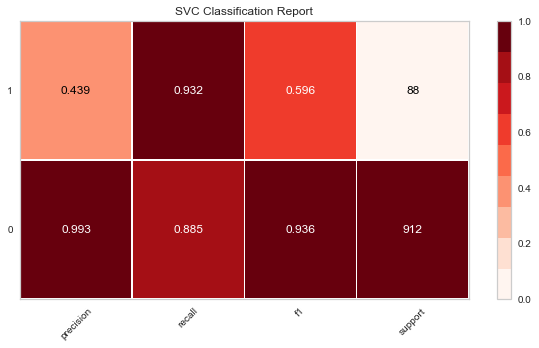

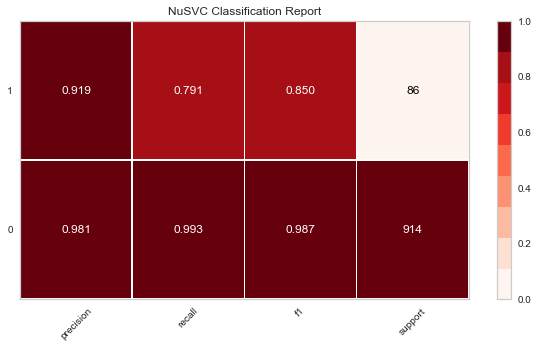

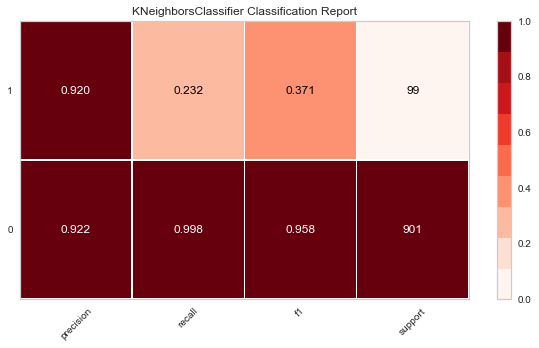

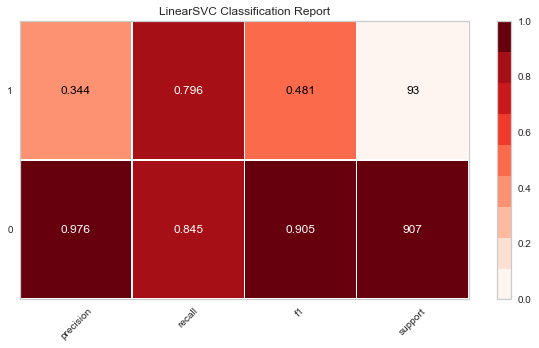

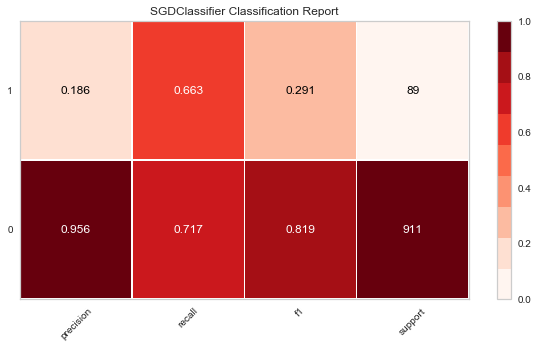

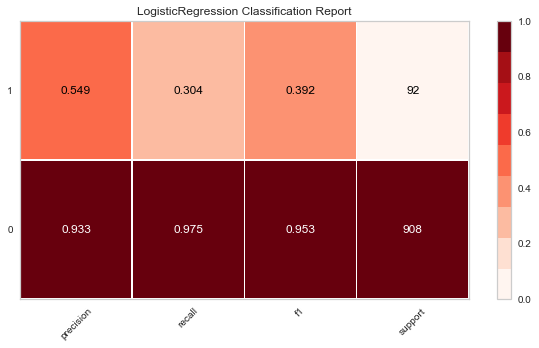

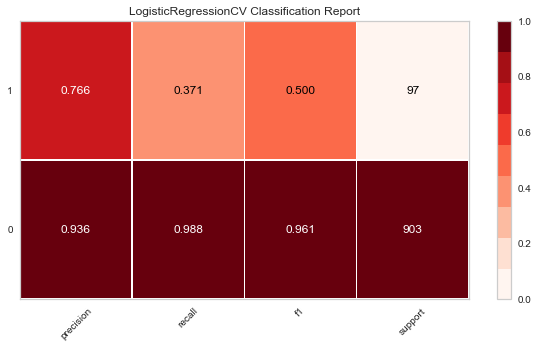

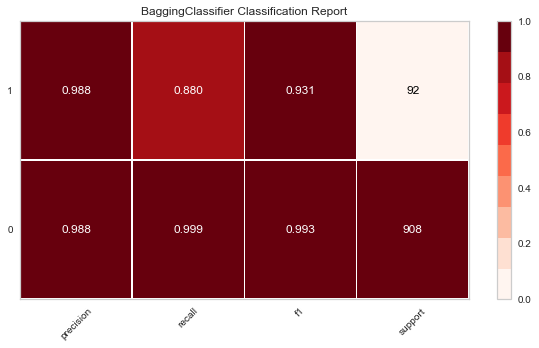

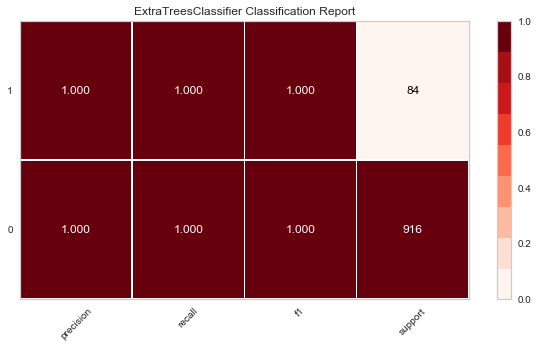

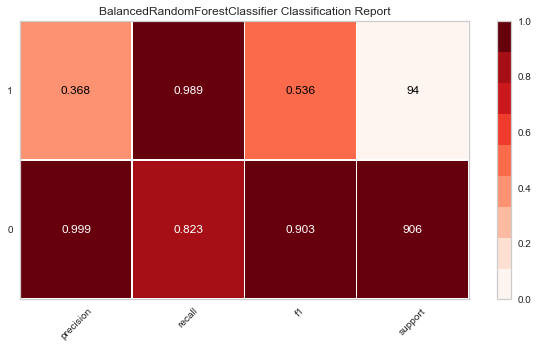

In [27]:
def visualize_model(X_std, y, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['0', '1'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X_std, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X_std, y, model)

## Cross Validation

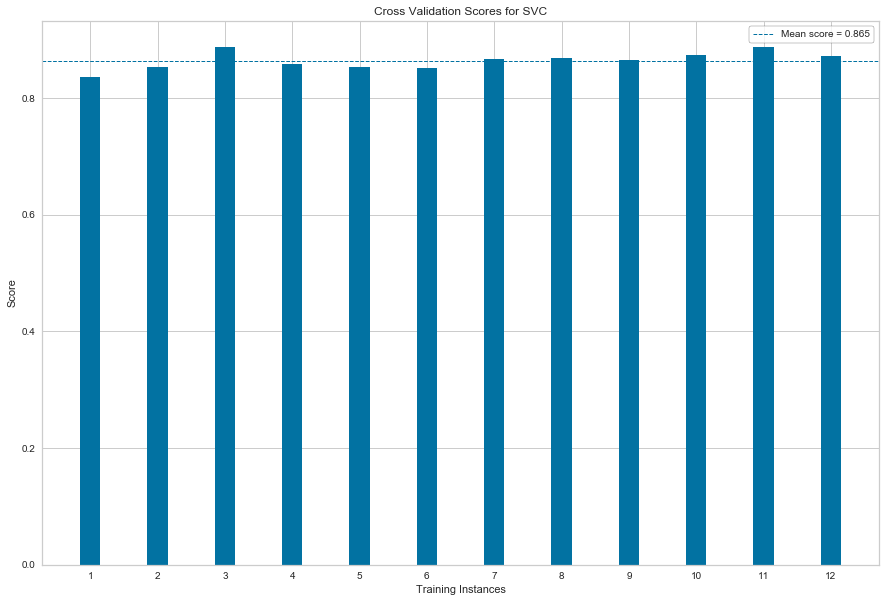

In [16]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = SVC(gamma='auto', class_weight='balanced')
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()

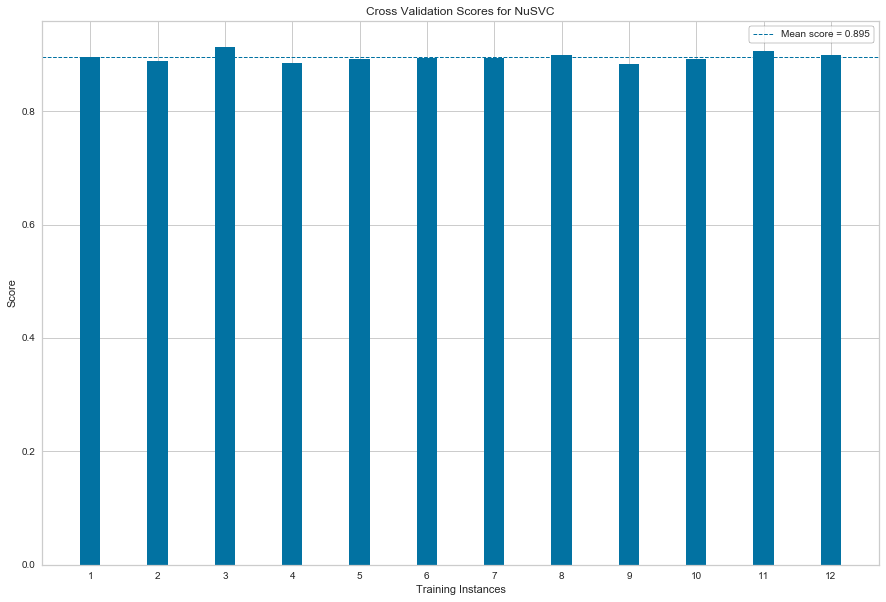

In [17]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = NuSVC(nu=0.1, gamma='auto', class_weight='balanced')
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()

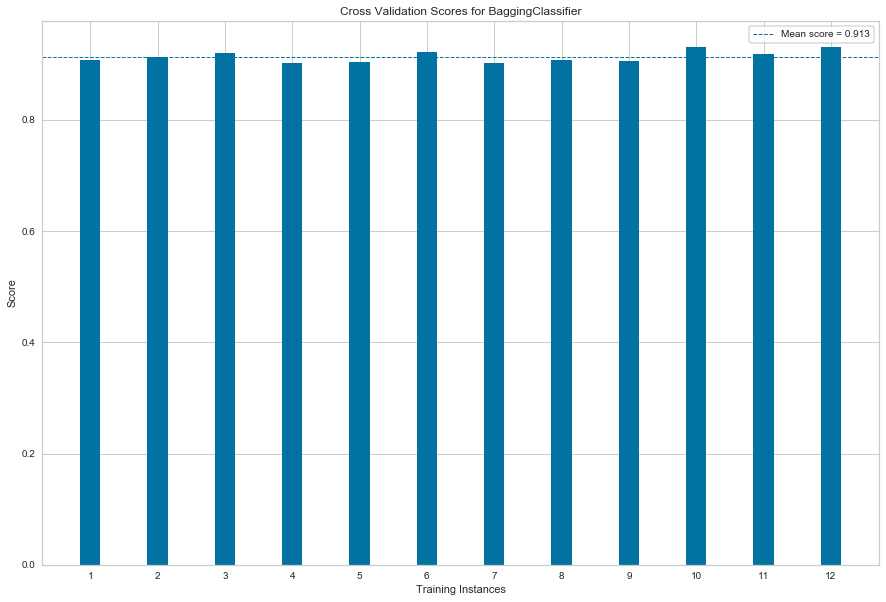

In [18]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = BaggingClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()

<bound method Visualizer.show of FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D90DD0908>,
          colormap=None, colors=None, is_fitted='auto',
          labels=Index(['nppes_provider_gender', 'medicare_prvdr_enroll_status',
       'other_suppress_flag', 'antipsych_bene_ge65_suppress_flg',
       'total_claim_count', 'total_30_day_fill_count', 'bene_count',
       'opioid_day_supply', 'la_opioid_day_supply', 'drug_cost_per_claim',
       'average_age...can Assistant',
       'nppes_credentials_RARE', 'nppes_credentials_unknown'],
      dtype='object'),
          model=None, relative=True, stack=False, xlabel=None)>

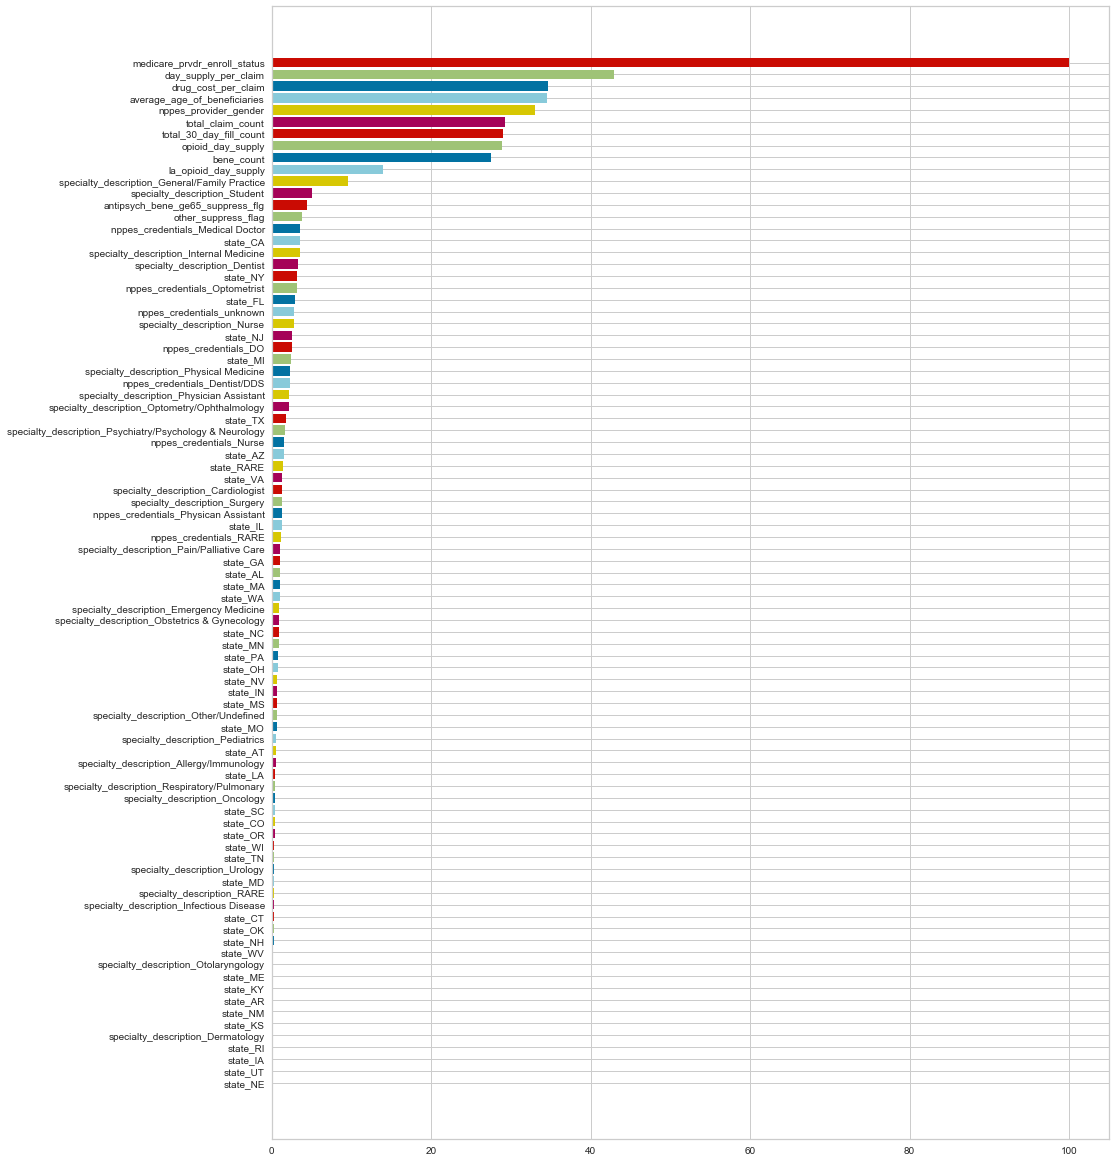

In [25]:
from yellowbrick.features import FeatureImportances

model= BalancedRandomForestClassifier()
viz=FeatureImportances(model, labels=features, size=(1080, 1500))
viz.fit(X_std, y)
viz.show

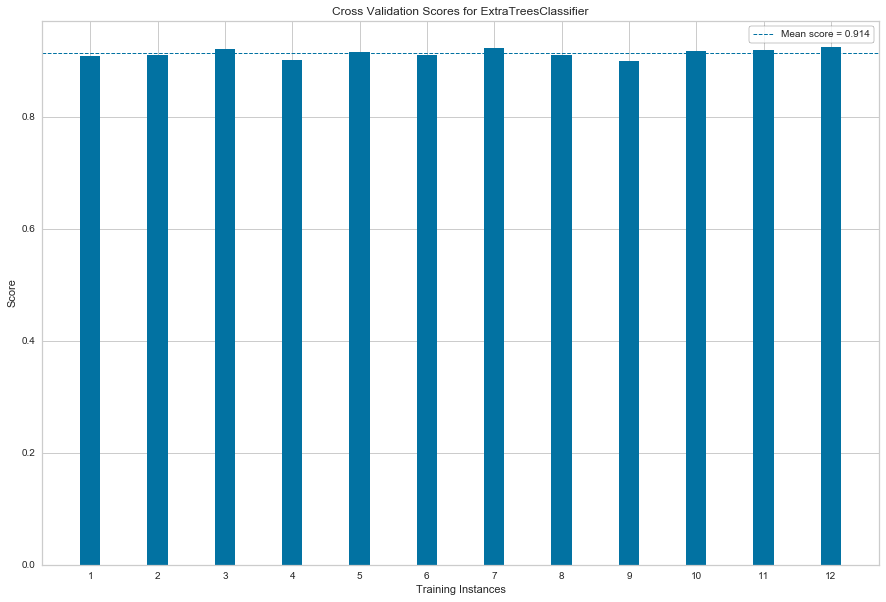

In [19]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = ExtraTreesClassifier(n_estimators=100, class_weight='balanced')
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()

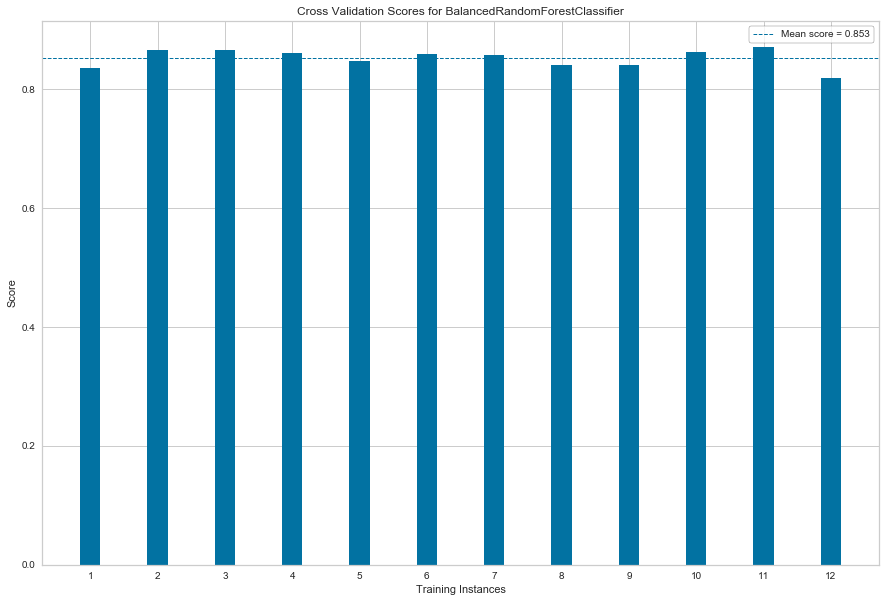

In [20]:
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = BalancedRandomForestClassifier(n_estimators=100)
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()